# Multivariate Normal Likelihood with Multivariate Normal Prior

This is a simple model where our data, $y$, is modelled as a multivariate normal RV with uncorrelated noise.

$L(x) = p(y | x) = \mathcal{N}[y \mid x,\Sigma]$

and

$p(x) = \mathcal{N}[x \mid \mu, \sigma^2 \mathbf{I}]$.

The analytic evidence for this model is,

$Z = p(y) = \mathcal{N}[y \mid \mu, \Sigma + \sigma^2 \mathbf{I}]$

The posterior is also a multivariate normal distribution,

$p(x \mid y) = \mathcal{N}[\mu', \Sigma']$

where

$\mu' = \sigma^2 \mathbf{I} (\sigma^2 \mathbf{I} + \Sigma)^{-1} y + \Sigma (
    \sigma^2 \mathbf{I} + \Sigma)^{-1}  \mu$

and

$\Sigma' = \sigma^2 \mathbf{I}  (\sigma^2 \mathbf{I}  + \Sigma)^{-1} \Sigma$


In [1]:

import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp

from jaxns import NestedSampler
from jaxns import Model
from jaxns import Prior

tfpd = tfp.distributions

/home/albert/miniconda3/envs/jaxns_py/lib/python3.11/site-packages/jaxns/internals/mixed_precision.py:15: UserWarning: JAX x64 is not enabled. Setting it now. Check for errors.
  warnings.warn("JAX x64 is not enabled. Setting it now. Check for errors.")
INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': 
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [2]:
from jax._src.scipy.linalg import solve_triangular


def log_normal(x, mean, cov):
    L = jnp.linalg.cholesky(cov)
    dx = x - mean
    dx = solve_triangular(L, dx, lower=True)
    return -0.5 * x.size * jnp.log(2. * jnp.pi) - jnp.sum(jnp.log(jnp.diag(L))) - 0.5 * dx @ dx


# define our data and prior
ndims = 16
prior_mu = 15 * jnp.ones(ndims)
prior_cov = jnp.diag(jnp.ones(ndims)) ** 2

data_mu = jnp.zeros(ndims)
data_cov = jnp.diag(jnp.ones(ndims)) ** 2
data_cov = jnp.where(data_cov == 0., 0.99, data_cov)

true_logZ = log_normal(data_mu, prior_mu, prior_cov + data_cov)

J = jnp.linalg.solve(data_cov + prior_cov, prior_cov)
post_mu = prior_mu + J.T @ (data_mu - prior_mu)
post_cov = prior_cov - J.T @ (prior_cov + data_cov) @ J

print("True logZ={}".format(true_logZ))
print("True post_mu={}".format(post_mu))
print("True post_cov={}".format(post_cov))


True logZ=-123.01474515709647
True post_mu=[14.10979228 14.10979228 14.10979228 14.10979228 14.10979228 14.10979228
 14.10979228 14.10979228 14.10979228 14.10979228 14.10979228 14.10979228
 14.10979228 14.10979228 14.10979228 14.10979228]
True post_cov=[[0.06807298 0.05817199 0.05817199 0.05817199 0.05817199 0.05817199
  0.05817199 0.05817199 0.05817199 0.05817199 0.05817199 0.05817199
  0.05817199 0.05817199 0.05817199 0.05817199]
 [0.05817199 0.06807298 0.05817199 0.05817199 0.05817199 0.05817199
  0.05817199 0.05817199 0.05817199 0.05817199 0.05817199 0.05817199
  0.05817199 0.05817199 0.05817199 0.05817199]
 [0.05817199 0.05817199 0.06807298 0.05817199 0.05817199 0.05817199
  0.05817199 0.05817199 0.05817199 0.05817199 0.05817199 0.05817199
  0.05817199 0.05817199 0.05817199 0.05817199]
 [0.05817199 0.05817199 0.05817199 0.06807298 0.05817199 0.05817199
  0.05817199 0.05817199 0.05817199 0.05817199 0.05817199 0.05817199
  0.05817199 0.05817199 0.05817199 0.05817199]
 [0.05817199 0.

In [3]:



def prior_model():
    x = yield Prior(tfpd.MultivariateNormalTriL(loc=prior_mu, scale_tril=jnp.linalg.cholesky(prior_cov)), name='x')
    return x


# The likelihood is a callable that will take
def log_likelihood(x):
    return log_normal(x, data_mu, data_cov)


model = Model(prior_model=prior_model,
              log_likelihood=log_likelihood)


In [4]:
import jax

# Create the nested sampler class. In this case without any tuning.
ns = NestedSampler(
    model=model,
    max_samples=1e6,
    parameter_estimation=True,
    verbose=True)

termination_reason, state = jax.jit(ns)(random.PRNGKey(42654))
results = ns.to_results(termination_reason=termination_reason, state=state)

# We can always save results to play with later
ns.save_results(results, 'save.json')
# loads previous results by uncommenting below
# results = load_results('save.json')



-------
Num samples: 4080
Num likelihood evals: 3597
Efficiency: 0.12509773260359655
log(L) contour: -824.6526150234295
log(Z) est.: -268.86378429991544 +- 0.8319300921560859
-------
Num samples: 8160
Num likelihood evals: 9954
Efficiency: 0.058515177374131415
log(L) contour: -664.5395182441953
log(Z) est.: -237.17982371896804 +- 0.8325533068393729
-------
Num samples: 12240
Num likelihood evals: 18567
Efficiency: 0.038806694154741694
log(L) contour: -557.4666135652756
log(Z) est.: -237.67982219651378 +- 0.833176036686431
-------
Num samples: 16320
Num likelihood evals: 29233
Efficiency: 0.028365441437182365
log(L) contour: -487.9330592378625
log(Z) est.: -238.17982075585252 +- 0.833798326831313
-------
Num samples: 20400
Num likelihood evals: 41667
Efficiency: 0.0234375
log(L) contour: -429.988545045173
log(Z) est.: -238.19375364069242 +- 0.7384847622727756
-------
Num samples: 24480
Num likelihood evals: 56007
Efficiency: 0.01949634443541836
log(L) contour: -385.7425064348372
log(Z) 

--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 4707709
samples: 404400
phantom samples: 380160
likelihood evals / sample: 11.6
phantom fraction (%): 94.0%
--------
logZ=-122.91 +- 0.36
max(logL)=-67.39
H=-33.83
ESS=2905
--------
x[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
x[0]: 14.09 +- 0.29 | 13.7 / 14.11 / 14.45 | 14.08 | 12.79
x[1]: 14.09 +- 0.28 | 13.71 / 14.1 / 14.44 | 14.13 | 12.86
x[2]: 14.09 +- 0.28 | 13.71 / 14.1 / 14.45 | 14.09 | 12.84
x[3]: 14.09 +- 0.29 | 13.7 / 14.1 / 14.45 | 14.04 | 12.99
x[4]: 14.09 +- 0.29 | 13.69 / 14.1 / 14.44 | 14.07 | 12.92
x[5]: 14.09 +- 0.28 | 13.7 / 14.1 / 14.45 | 14.13 | 12.81
x[6]: 14.09 +- 0.28 | 13.7 / 14.1 / 14.45 | 14.08 | 12.83
x[7]: 14.09 +- 0.28 | 13.7 / 14.11 / 14.44 | 14.02 | 12.92
x[8]: 14.09 +- 0.28 | 13.71 / 14.1 / 14.45 | 14.03 | 12.9
x[9]: 14.09 +- 0.29 | 13.7 / 14.1 / 14.45 | 14.12 | 12.86
x[10]: 14.09 +- 0.28 | 13.7 / 14.11 / 14.45 | 14.06 | 12.79
x[11]: 14.09 

/home/albert/miniconda3/envs/jaxns_py/lib/python3.11/site-packages/jaxns/plotting.py:48: UserWarning: Found samples with zero likelihood evaluations.
  warnings.warn("Found samples with zero likelihood evaluations.")
/home/albert/miniconda3/envs/jaxns_py/lib/python3.11/site-packages/jaxns/plotting.py:52: RuntimeWarning: divide by zero encountered in divide
  1. / num_likelihood_evaluations_per_sample


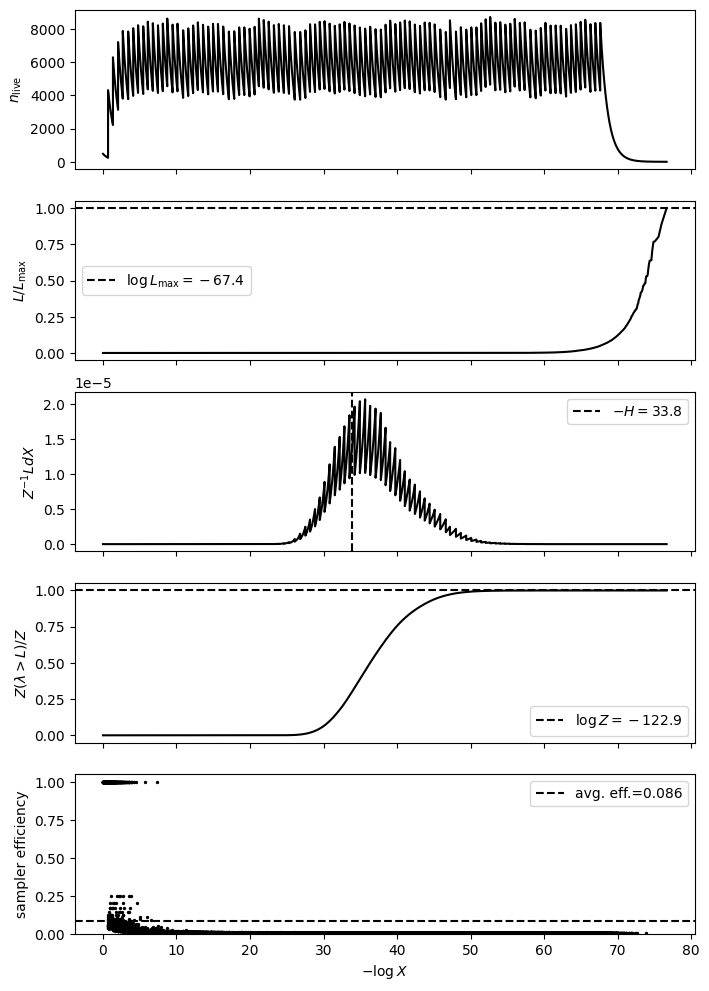

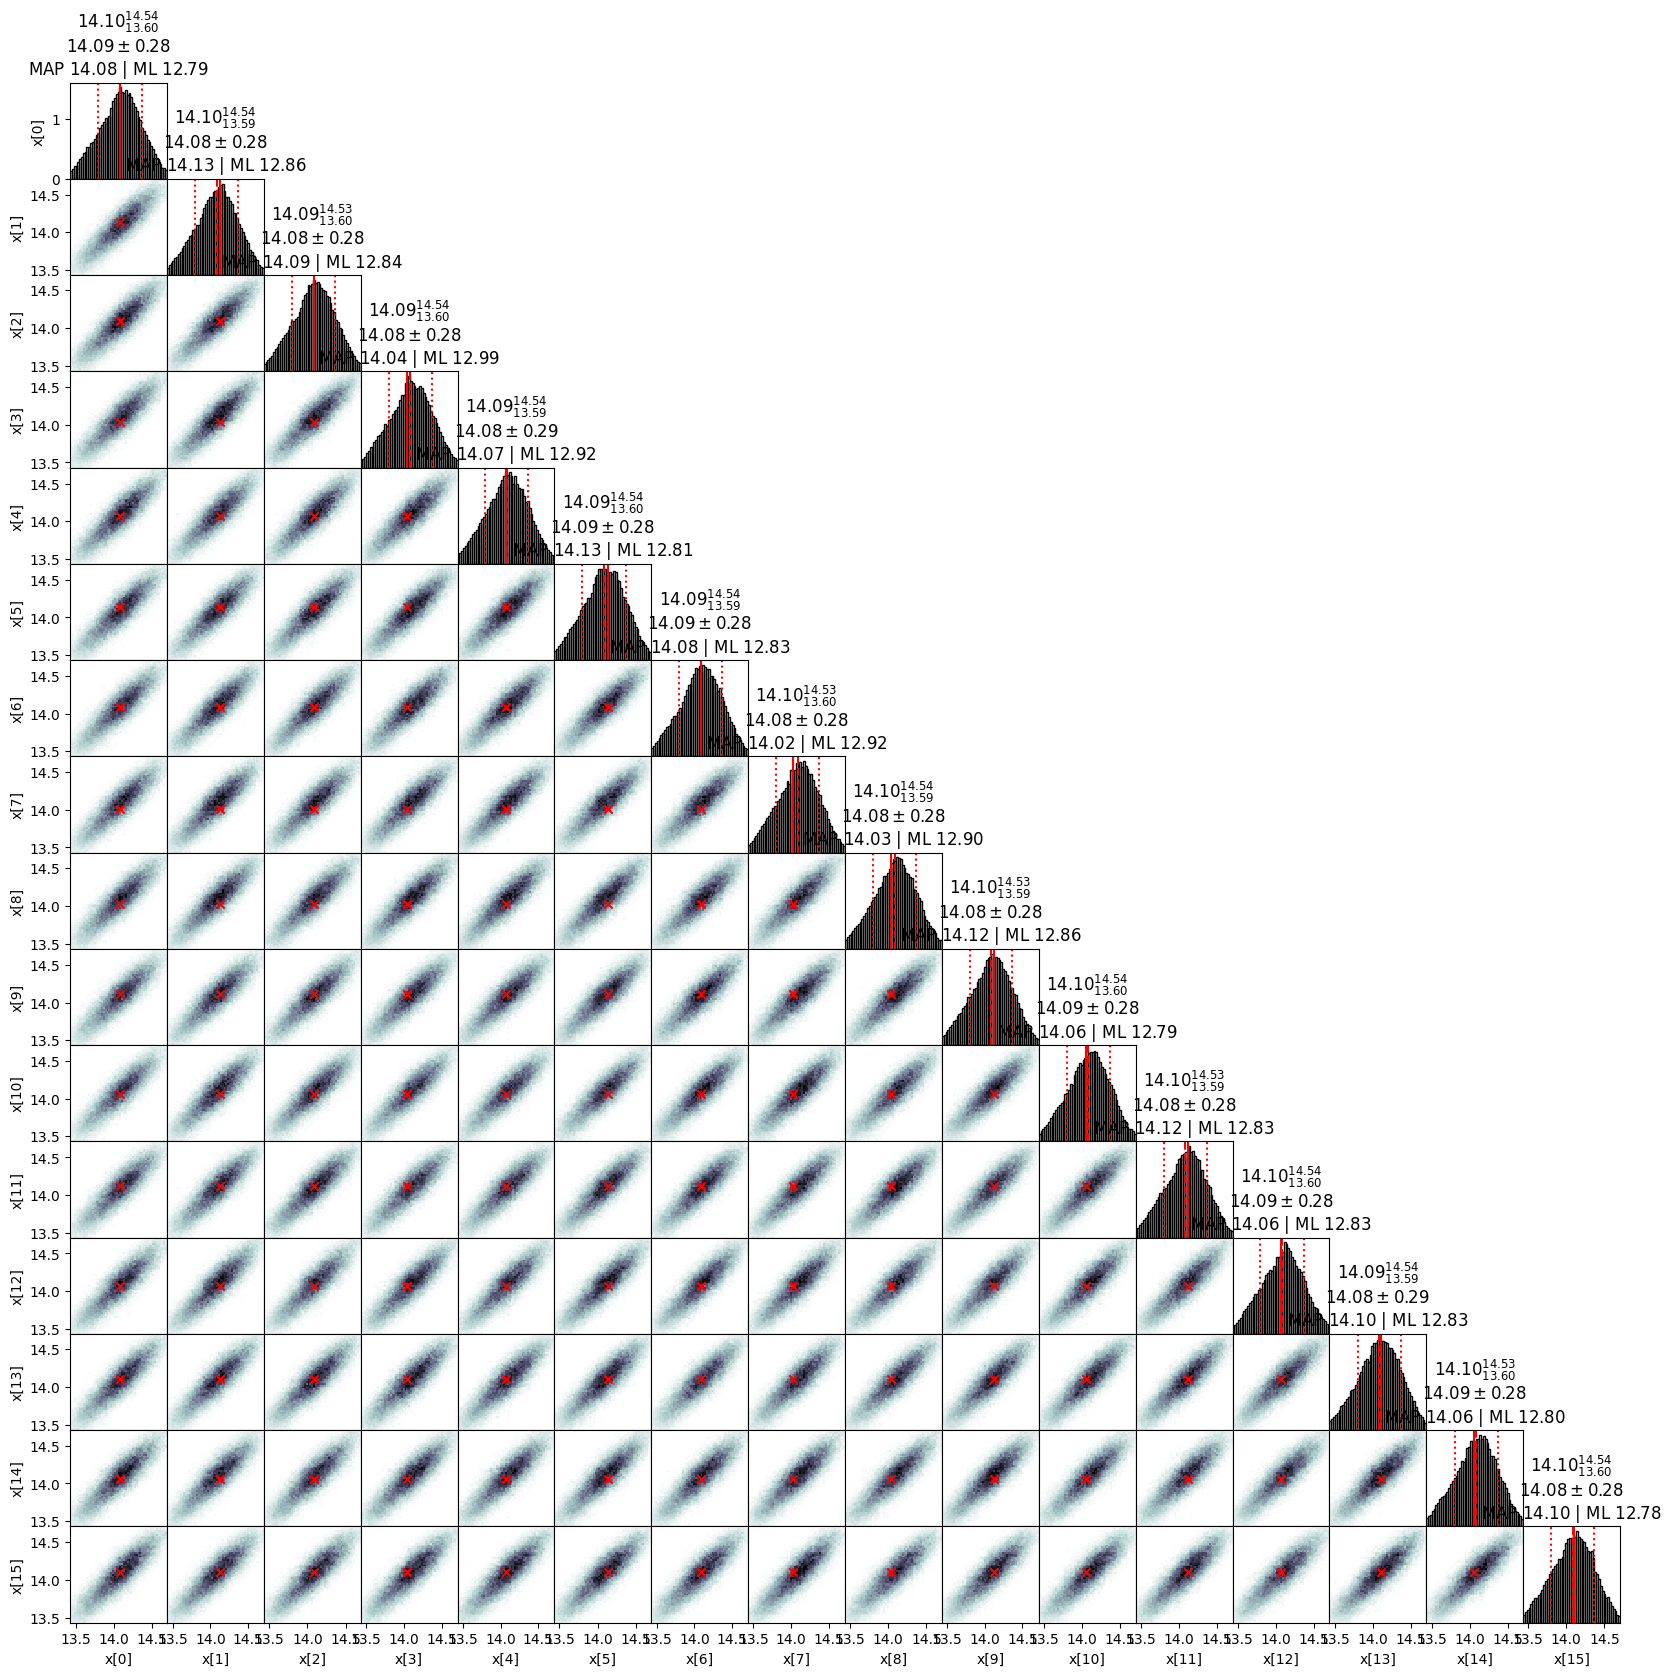

In [5]:
# We can use the summary utility to display results
ns.summary(results)
# We plot useful diagnostics and a distribution cornerplot
ns.plot_diagnostics(results)
ns.plot_cornerplot(results)
